In [47]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import ifft, fft, fftfreq, fftshift, ifft2, fft2
from scipy import signal
from scipy.io import wavfile
import sklearn
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd

In [48]:
sample_rate, audio_data = wavfile.read('ExpSummer2024/TASCAM_0016S3.wav')

print(f"Частота дискретизации: {sample_rate} Гц")
print(f"Форма массива данных: {audio_data.shape}")
print(audio_data)

def plot1 (Y1, X1):
    plt.plot(X1, Y1, color='blue')
    # plt.xlim(-freq_filt,freq_filt)
    plt.show()
    
def plot2 (Y1, X1, Y2, X2):
    # plt.plot(X1, Y1, label = label1, color='blue')
    plt.plot(X2, Y2, color='red')
    plt.plot(X1, Y1, color='blue')
    # plt.xlim(-2000,2000)
    plt.legend()
    plt.grid(True)
    plt.show()

def corr_f(data1, data2, f1):
    mn = len(data1)
    data10 = ifft(data1)
    data20 = ifft(data2)
    s1 = np.zeros(mn)
    s2 = np.zeros(mn)
    f = fftfreq(mn, 1 / sample_rate)
    for i in range (0, mn):
        if f[i] > -f1:
            if f[i] < f1:
                s1[i] = data10[i]
                s2[i] = data20[i]
    corr_f = ifft(fft((np.abs(s1))**2)*np.conj(fft((np.abs(s2))**2)))
    return corr_f

t = np.arange(int(len(audio_data)))/sample_rate # Массив времен


Частота дискретизации: 44100 Гц
Форма массива данных: (189858816,)
[   0 -256 -256 ...  768  256    0]


In [49]:
df = pd.read_excel('Conducting an experiment 30_08.xlsx')
print(df)


    ID Start time  Duration                 БПЛА Высота Дальность Скорость  \
0    1   14:48:10  00:01:25                    -      -         -        -   
1    2   14:49:40  00:01:02                    -      -         -        -   
2    3   14:52:24  00:00:23       DJI Mini 4 Pro      -         -        -   
3    4   14:52:55  00:00:33       DJI Mini 4 Pro      -         -        -   
4    5   14:54:11  00:01:01       DJI Mini 4 Pro     50        50      NaN   
5    6   14:55:32  00:00:41       DJI Mini 4 Pro    100       100        -   
6    7   14:56:30  00:00:30       DJI Mini 4 Pro    100       200        -   
7    8   14:57:17  00:00:33       DJI Mini 4 Pro    100       300        -   
8    9   14:57:56  00:01:09       DJI Mini 4 Pro    100       300       14   
9   10   14:59:11  00:01:03       DJI Mini 4 Pro    100      -300       14   
10  11   15:01:37  00:00:57       DJI Mini 4 Pro     50       300       14   
11  12   15:02:43  00:01:45       DJI Mini 4 Pro     25      -30

In [53]:
print(df.loc[0, 'Start time'])

14:48:10


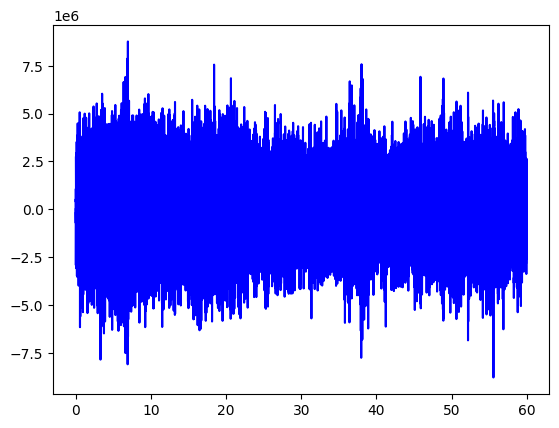

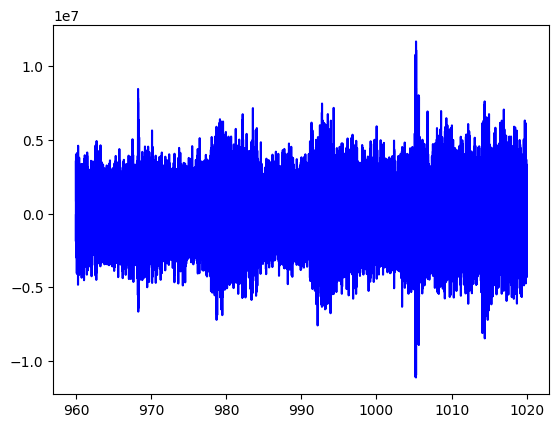

/var/folders/lf/x86pzptd3pv7z45l56wggyjc0000gn/T/ipykernel_7633/1031961253.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  s1[i] = data10[i]
/var/folders/lf/x86pzptd3pv7z45l56wggyjc0000gn/T/ipykernel_7633/1031961253.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  s2[i] = data20[i]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


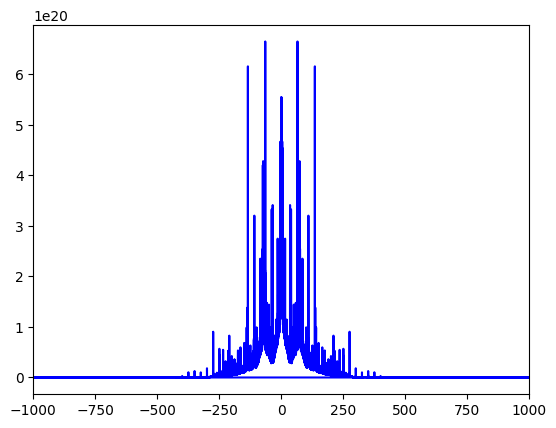

In [37]:
t_int1 = (t < 60) & (t > 0)
t_int2 = (t < 1020) & (t > 960)
t1 = t[t_int1]
t2 = t[t_int2]
f = fftfreq(int(len(t1)), 1 / sample_rate) # Массив частот
audio_data1 = audio_data[t_int1]
audio_data2= audio_data[t_int2]
y1 = ifft(audio_data1)
y2 = ifft(audio_data2)

plt.plot(t1, audio_data1, color='blue', label='Small')
plt.show()

plt.plot(t2, audio_data2, color='blue', label='Small')
plt.show()

plt.plot(f, corr_f(audio_data1, audio_data2, 250), color='blue')
plt.xlim(-1000, 1000)
plt.show()



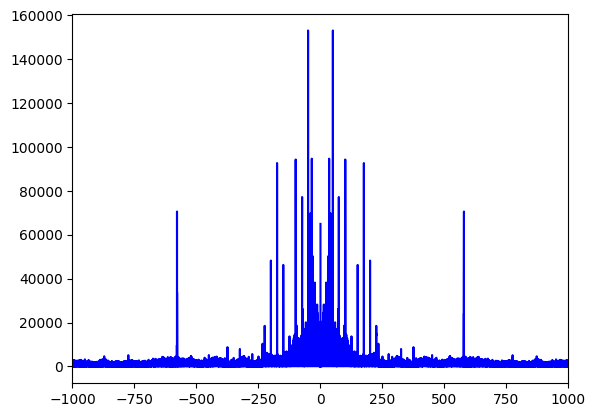

In [38]:
plt.plot(f, np.abs(y1), color='blue', label='Small')
plt.xlim([-1000, 1000])
plt.show()
